## Benchmark for measuring performance of engineered features and models

Use all the time series features to in model training.

In [1]:
import sys
sys.path.insert(0, '../../bosch_helper')
from bosch_helper import *

%matplotlib inline

/c3se/NOBACKUP/users/lyaa/conda_dir/miniconda/envs/kaggle/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


### Time Series Featrues

First do Fourier transform or autocorrelation on the time series, find the period in time. Then create the following features:
- StartStationTimes
    * Start time on each station
- StartTime, EndTime, Duration
    * Overall start and end time and duration of production
- StationTimeDiff
    * The time interval between two neighboring stations?
- Start/End part of week (mod 1680)
    * Fourier transform
    * Autocorrelation
- Number of records in next/last 2.5h, 24h, 168h for each station
    * First convert numeric to `deltatime` by `x['time_start'] = pd.to_deltatime(x['time_start'], unit='h')`
    * `df.rolling(window='60min', on='time_start')['counts'].sum()`
- Number of records in the same time (6 mins)
- MeanTimeDiff since last 1/5/10 failure(s)
- MeanTimeDiff till next 1/5/10 failure(s)

### Load train and test data

In [2]:
# important numeric features are imported
important_features = pd.read_csv('../benchmark_1/important_numeric_features.csv', index_col=0, header=None)
important_features = list(important_features.values.ravel())
important_features.extend(['Id', 'Response'])

In [3]:
x_train_numeric = pd.read_csv('../../data/train_numeric.csv.zip', index_col=0, usecols=important_features, dtype=np.float32)

y_train = x_train_numeric.Response
x_train_numeric.drop(['Response'], axis=1, inplace=True)

In [4]:
date_train = pd.read_csv('../benchmark_2/train_station_flow.csv.gz', index_col=0, header=None)

In [5]:
x_train = x_train_numeric.join(date_train)

columns = list(x_train.columns)
columns[-1] = 'station_flow'
x_train.columns = columns

In [6]:
x_test_numeric = pd.read_csv('../../data/test_numeric.csv.zip', index_col=0, usecols=important_features[:-1], dtype=np.float32)

date_test = pd.read_csv('../benchmark_2/test_station_flow.csv.gz', index_col=0, header=None)

x_test = x_test_numeric.join(date_test)
x_test.columns = columns

In [7]:
x_train.index = x_train.index.astype(np.int64)
x_test.index = x_test.index.astype(np.int64)

In [8]:
del x_train_numeric, x_test_numeric
gc.collect()

60

### Load benchmark_3 features

In [9]:
start_chunk = pd.read_csv('../benchmark_3/start_chunk.csv.gz', index_col=0)

start_chunk_train = start_chunk.loc[start_chunk.Response!=-1].drop(['Response'], axis=1)
start_chunk_test = start_chunk.loc[start_chunk.Response==-1].drop(['Response'], axis=1)

In [10]:
x_train = x_train.join(start_chunk_train, on='Id')
x_test = x_test.join(start_chunk_test, on='Id')

gc.collect()

35

### Load benchmark_4 features

In [11]:
n = pd.read_csv('../benchmark_4/benchmark_4_neighbors.csv.gz', index_col=0)

neighbor_train = n.loc[n.Response!=-1]
neighbor_train.drop(['Response'], axis=1, inplace=True)

neighbor_test = n.loc[n.Response==-1]
neighbor_test.drop(['Response'], axis=1, inplace=True)

print(neighbor_test.shape, neighbor_train.shape)

x_train = x_train.join(neighbor_train, on='Id')
x_test = x_test.join(neighbor_test, on='Id')

gc.collect()

(1183748, 14) (1183747, 14)


28

### Add neighbor numeric features
The important numeric features selected from previous and next records

In [12]:
# Date + station flow data will be added to x
x = pd.concat([x_train, x_test], keys=['train', 'test'])
x.sort_index(axis=0, level='Id', inplace=True)

# Add the neighbor records
x = x.join(x.iloc[:, :150].shift(), rsuffix='_previous')
x = x.join(x.iloc[:, :150].shift(-1), rsuffix='_next')

In [13]:
x_train = x.loc['train']
x_test = x.loc['test']

In [14]:
del x
gc.collect()

63

### Load benchmark_7 features

Time series features

In [15]:
time_features = pd.read_hdf('time_features_diff.hdf', 'time_features')
time_features.drop(['time_start', 'time_end', 'time_duration', 'Response'], axis=1, inplace=True)

In [16]:
mean_diff_cols = time_features.iloc[:, -40:].columns.tolist()

In [17]:
# Do not use MeanTimeDiff features
x_train = x_train.join(time_features.loc['train'])
x_test = x_test.join(time_features.loc['test'])

In [18]:
print(x_train.shape, x_test.shape)

(1183747, 794) (1183748, 794)


In [19]:
del time_features
gc.collect()

100

In [20]:
# x_train.drop(['Response'], axis=1, inplace=True)
# x_test.drop(['Response'], axis=1, inplace=True)

### CV score based on stratified KFold with repeated models

In [23]:
# CV
# specify parameters 
# 'booster':'gbtree'
params = {'max_depth':14, 'eta':0.03, 'silent':1, 'objective':'binary:logistic', 'nthread':20,
         'lambda':4, 'subsample':0.9, 'min_child_weight':5, 'booster':'gbtree', 'alpha':0,
         'base_score':0.0058, 'colsample_bytree':0.6}

# 'booster':'dart'
# params = {'max_depth':14, 'eta':0.03, 'silent':1, 'objective':'binary:logistic', 'nthread':20,
#         'lambda':4, 'subsample':0.9, 'min_child_weight':5, 'booster':'dart', 'alpha':0,
#         'base_score':0.0058, 'nthread':20, 'colsample_bytree':0.6, 
#         'sample_type':'uniform', 'normalize_type':'tree', 'rate_drop':0.1, 'skip_drop':0.2, 'one_drop':True}

cv_results, clfs, running_time = cross_val_predict_skf_rm_xgb(params, x_train, y_train, 
                                                              num_boost_round=80, n_splits=5, 
                                                              n_repeats=3, random_state=5870577, 
                                                              verbose_eval=True)

results = {'clfs': clfs, 'cv_results': cv_results, 'running_time': running_time}
save_pickle(results, 'results_benchmark_7_time_features_cv_1.pickle')

[0]	train-error:0.005811	test-error:0.005812	train-MCC:0.3049	test-MCC:0.301217
[1]	train-error:0.005811	test-error:0.005812	train-MCC:0.345647	test-MCC:0.346206
[2]	train-error:0.005811	test-error:0.005812	train-MCC:0.375805	test-MCC:0.358225
[3]	train-error:0.005811	test-error:0.005812	train-MCC:0.38922	test-MCC:0.373046
[4]	train-error:0.005811	test-error:0.005812	train-MCC:0.408131	test-MCC:0.383514
[5]	train-error:0.005811	test-error:0.005812	train-MCC:0.411843	test-MCC:0.385817
[6]	train-error:0.005811	test-error:0.005812	train-MCC:0.416256	test-MCC:0.388972
[7]	train-error:0.005811	test-error:0.005812	train-MCC:0.421358	test-MCC:0.394317
[8]	train-error:0.005811	test-error:0.005812	train-MCC:0.427226	test-MCC:0.399034
[9]	train-error:0.005811	test-error:0.005812	train-MCC:0.427605	test-MCC:0.39528
[10]	train-error:0.005811	test-error:0.005812	train-MCC:0.429684	test-MCC:0.397016
[11]	train-error:0.005811	test-error:0.005812	train-MCC:0.436722	test-MCC:0.396836
[12]	train-error:0

[19]	train-error:0.005664	test-error:0.005668	train-MCC:0.484058	test-MCC:0.420482
[20]	train-error:0.005605	test-error:0.005626	train-MCC:0.487452	test-MCC:0.421026
[21]	train-error:0.005548	test-error:0.005559	train-MCC:0.490216	test-MCC:0.421296
[22]	train-error:0.005487	test-error:0.005495	train-MCC:0.492085	test-MCC:0.422695
[23]	train-error:0.005439	test-error:0.005432	train-MCC:0.493903	test-MCC:0.423755
[24]	train-error:0.005407	test-error:0.005398	train-MCC:0.495789	test-MCC:0.424777
[25]	train-error:0.005371	test-error:0.005373	train-MCC:0.497408	test-MCC:0.423653
[26]	train-error:0.005331	test-error:0.005339	train-MCC:0.500409	test-MCC:0.42286
[27]	train-error:0.005308	test-error:0.005305	train-MCC:0.504017	test-MCC:0.423653
[28]	train-error:0.005246	test-error:0.005263	train-MCC:0.50694	test-MCC:0.424764
[29]	train-error:0.005199	test-error:0.005212	train-MCC:0.507979	test-MCC:0.423734
[30]	train-error:0.005174	test-error:0.0052	train-MCC:0.509715	test-MCC:0.424488
[31]	tra

[38]	train-error:0.00495	test-error:0.005073	train-MCC:0.521933	test-MCC:0.442157
[39]	train-error:0.004932	test-error:0.005069	train-MCC:0.524134	test-MCC:0.442514
[40]	train-error:0.004913	test-error:0.005048	train-MCC:0.525375	test-MCC:0.443064
[41]	train-error:0.004895	test-error:0.005039	train-MCC:0.527267	test-MCC:0.443064
[42]	train-error:0.004871	test-error:0.005018	train-MCC:0.528281	test-MCC:0.443368
[43]	train-error:0.004851	test-error:0.004988	train-MCC:0.530458	test-MCC:0.444204
[44]	train-error:0.004829	test-error:0.00498	train-MCC:0.531676	test-MCC:0.44482
[45]	train-error:0.004812	test-error:0.004976	train-MCC:0.533036	test-MCC:0.44287
[46]	train-error:0.0048	test-error:0.004942	train-MCC:0.53434	test-MCC:0.442843
[47]	train-error:0.004785	test-error:0.004925	train-MCC:0.536826	test-MCC:0.442037
[48]	train-error:0.00477	test-error:0.004912	train-MCC:0.538371	test-MCC:0.442581
[49]	train-error:0.004756	test-error:0.004912	train-MCC:0.540401	test-MCC:0.443895
[50]	train-e

[57]	train-error:0.00465	test-error:0.004853	train-MCC:0.574318	test-MCC:0.454942
[58]	train-error:0.004642	test-error:0.004845	train-MCC:0.574361	test-MCC:0.45393
[59]	train-error:0.004636	test-error:0.004841	train-MCC:0.576838	test-MCC:0.454213
[60]	train-error:0.004625	test-error:0.004824	train-MCC:0.577739	test-MCC:0.455187
[61]	train-error:0.004612	test-error:0.004824	train-MCC:0.578976	test-MCC:0.453655
[62]	train-error:0.004596	test-error:0.004815	train-MCC:0.581389	test-MCC:0.453529
[63]	train-error:0.004586	test-error:0.004803	train-MCC:0.582923	test-MCC:0.454421
[64]	train-error:0.004582	test-error:0.004794	train-MCC:0.585633	test-MCC:0.455193
[65]	train-error:0.004578	test-error:0.00479	train-MCC:0.587667	test-MCC:0.455297
[66]	train-error:0.00457	test-error:0.004786	train-MCC:0.589919	test-MCC:0.454218
[67]	train-error:0.004558	test-error:0.004777	train-MCC:0.594076	test-MCC:0.455517
[68]	train-error:0.004551	test-error:0.004773	train-MCC:0.595773	test-MCC:0.454942
[69]	tra

[76]	train-error:0.004514	test-error:0.004705	train-MCC:0.592328	test-MCC:0.460765
[77]	train-error:0.004508	test-error:0.004697	train-MCC:0.593389	test-MCC:0.460621
[78]	train-error:0.004502	test-error:0.004693	train-MCC:0.594826	test-MCC:0.460621
[79]	train-error:0.004496	test-error:0.004689	train-MCC:0.596437	test-MCC:0.460621
Repeat 0, split 4, test MCC = 0.461, running time = 7.205 min
[0]	train-error:0.005811	test-error:0.005812	train-MCC:0.268383	test-MCC:0.251232
[1]	train-error:0.005811	test-error:0.005812	train-MCC:0.29896	test-MCC:0.278133
[2]	train-error:0.005811	test-error:0.005812	train-MCC:0.337436	test-MCC:0.328174
[3]	train-error:0.005811	test-error:0.005812	train-MCC:0.363478	test-MCC:0.351079
[4]	train-error:0.005811	test-error:0.005812	train-MCC:0.380644	test-MCC:0.370882
[5]	train-error:0.005811	test-error:0.005812	train-MCC:0.388448	test-MCC:0.375358
[6]	train-error:0.005811	test-error:0.005812	train-MCC:0.400307	test-MCC:0.385596
[7]	train-error:0.005811	test-err

[14]	train-error:0.005809	test-error:0.005812	train-MCC:0.461795	test-MCC:0.418084
[15]	train-error:0.005809	test-error:0.005808	train-MCC:0.46803	test-MCC:0.419339
[16]	train-error:0.005809	test-error:0.005808	train-MCC:0.468813	test-MCC:0.421335
[17]	train-error:0.005809	test-error:0.005804	train-MCC:0.471531	test-MCC:0.422006
[18]	train-error:0.005796	test-error:0.005782	train-MCC:0.47363	test-MCC:0.425674
[19]	train-error:0.005772	test-error:0.005774	train-MCC:0.476999	test-MCC:0.426456
[20]	train-error:0.005737	test-error:0.005728	train-MCC:0.480074	test-MCC:0.429367
[21]	train-error:0.005692	test-error:0.005685	train-MCC:0.484586	test-MCC:0.428336
[22]	train-error:0.00565	test-error:0.005656	train-MCC:0.486166	test-MCC:0.430453
[23]	train-error:0.005606	test-error:0.005601	train-MCC:0.488321	test-MCC:0.432667
[24]	train-error:0.005535	test-error:0.005563	train-MCC:0.490972	test-MCC:0.431581
[25]	train-error:0.005479	test-error:0.005504	train-MCC:0.493181	test-MCC:0.434557
[26]	tr

[33]	train-error:0.005084	test-error:0.005204	train-MCC:0.509157	test-MCC:0.447682
[34]	train-error:0.005043	test-error:0.005174	train-MCC:0.51131	test-MCC:0.447207
[35]	train-error:0.005016	test-error:0.00514	train-MCC:0.514356	test-MCC:0.44789
[36]	train-error:0.004986	test-error:0.005124	train-MCC:0.516174	test-MCC:0.448422
[37]	train-error:0.004972	test-error:0.005102	train-MCC:0.518001	test-MCC:0.448866
[38]	train-error:0.004956	test-error:0.005086	train-MCC:0.52109	test-MCC:0.449289
[39]	train-error:0.004933	test-error:0.005064	train-MCC:0.522791	test-MCC:0.448635
[40]	train-error:0.004914	test-error:0.005056	train-MCC:0.525557	test-MCC:0.451347
[41]	train-error:0.004905	test-error:0.005039	train-MCC:0.527004	test-MCC:0.451374
[42]	train-error:0.00489	test-error:0.005031	train-MCC:0.528391	test-MCC:0.45194
[43]	train-error:0.004868	test-error:0.005005	train-MCC:0.530784	test-MCC:0.45185
[44]	train-error:0.004855	test-error:0.004984	train-MCC:0.533025	test-MCC:0.450309
[45]	train-

[52]	train-error:0.004758	test-error:0.004938	train-MCC:0.546366	test-MCC:0.444194
[53]	train-error:0.004747	test-error:0.004938	train-MCC:0.547311	test-MCC:0.445099
[54]	train-error:0.004731	test-error:0.004933	train-MCC:0.548871	test-MCC:0.445236
[55]	train-error:0.004725	test-error:0.004933	train-MCC:0.552137	test-MCC:0.44602
[56]	train-error:0.004715	test-error:0.004925	train-MCC:0.55348	test-MCC:0.44751
[57]	train-error:0.004706	test-error:0.004908	train-MCC:0.55467	test-MCC:0.446795
[58]	train-error:0.004693	test-error:0.004908	train-MCC:0.557816	test-MCC:0.446671
[59]	train-error:0.004679	test-error:0.0049	train-MCC:0.559405	test-MCC:0.44736
[60]	train-error:0.004668	test-error:0.004891	train-MCC:0.56002	test-MCC:0.446922
[61]	train-error:0.00465	test-error:0.004883	train-MCC:0.562035	test-MCC:0.448119
[62]	train-error:0.004638	test-error:0.00487	train-MCC:0.563065	test-MCC:0.449021
[63]	train-error:0.004621	test-error:0.004862	train-MCC:0.564831	test-MCC:0.447907
[64]	train-err

[71]	train-error:0.004524	test-error:0.004701	train-MCC:0.586511	test-MCC:0.461417
[72]	train-error:0.004517	test-error:0.004701	train-MCC:0.589221	test-MCC:0.462769
[73]	train-error:0.00451	test-error:0.004697	train-MCC:0.592017	test-MCC:0.463853
[74]	train-error:0.004501	test-error:0.004701	train-MCC:0.59344	test-MCC:0.463853
[75]	train-error:0.004491	test-error:0.004693	train-MCC:0.596106	test-MCC:0.463853
[76]	train-error:0.004485	test-error:0.004693	train-MCC:0.597644	test-MCC:0.462603
[77]	train-error:0.004483	test-error:0.004693	train-MCC:0.598774	test-MCC:0.464694
[78]	train-error:0.004476	test-error:0.00468	train-MCC:0.601431	test-MCC:0.464035
[79]	train-error:0.004466	test-error:0.004676	train-MCC:0.602996	test-MCC:0.462658
Repeat 1, split 4, test MCC = 0.463, running time = 7.121 min
[0]	train-error:0.005811	test-error:0.005812	train-MCC:0.264597	test-MCC:0.251503
[1]	train-error:0.005811	test-error:0.005812	train-MCC:0.329919	test-MCC:0.306704
[2]	train-error:0.005811	test-

[9]	train-error:0.005811	test-error:0.005812	train-MCC:0.431931	test-MCC:0.394696
[10]	train-error:0.005811	test-error:0.005812	train-MCC:0.442219	test-MCC:0.403952
[11]	train-error:0.005811	test-error:0.005812	train-MCC:0.448456	test-MCC:0.408105
[12]	train-error:0.005811	test-error:0.005812	train-MCC:0.452745	test-MCC:0.412658
[13]	train-error:0.005811	test-error:0.005812	train-MCC:0.460071	test-MCC:0.4157
[14]	train-error:0.005811	test-error:0.005812	train-MCC:0.463326	test-MCC:0.4208
[15]	train-error:0.005811	test-error:0.005812	train-MCC:0.466784	test-MCC:0.422957
[16]	train-error:0.005811	test-error:0.005812	train-MCC:0.469746	test-MCC:0.423435
[17]	train-error:0.005811	test-error:0.005812	train-MCC:0.473044	test-MCC:0.426565
[18]	train-error:0.005811	test-error:0.005812	train-MCC:0.477546	test-MCC:0.429623
[19]	train-error:0.005762	test-error:0.005787	train-MCC:0.479259	test-MCC:0.430081
[20]	train-error:0.005727	test-error:0.005757	train-MCC:0.48141	test-MCC:0.431627
[21]	train

[28]	train-error:0.005325	test-error:0.005453	train-MCC:0.498683	test-MCC:0.435658
[29]	train-error:0.005274	test-error:0.005415	train-MCC:0.501523	test-MCC:0.439118
[30]	train-error:0.005221	test-error:0.005369	train-MCC:0.504324	test-MCC:0.440381
[31]	train-error:0.005181	test-error:0.005326	train-MCC:0.50782	test-MCC:0.44021
[32]	train-error:0.005146	test-error:0.00528	train-MCC:0.508642	test-MCC:0.440443
[33]	train-error:0.005111	test-error:0.005242	train-MCC:0.511585	test-MCC:0.442551
[34]	train-error:0.005081	test-error:0.005208	train-MCC:0.513954	test-MCC:0.443743
[35]	train-error:0.005043	test-error:0.005183	train-MCC:0.514703	test-MCC:0.446197
[36]	train-error:0.005019	test-error:0.005162	train-MCC:0.51728	test-MCC:0.446574
[37]	train-error:0.004988	test-error:0.005119	train-MCC:0.519579	test-MCC:0.4463
[38]	train-error:0.004962	test-error:0.005086	train-MCC:0.521059	test-MCC:0.448068
[39]	train-error:0.004925	test-error:0.00506	train-MCC:0.522774	test-MCC:0.446708
[40]	train-

[47]	train-error:0.004782	test-error:0.004955	train-MCC:0.546032	test-MCC:0.44736
[48]	train-error:0.004768	test-error:0.004929	train-MCC:0.548727	test-MCC:0.4489
[49]	train-error:0.004753	test-error:0.004904	train-MCC:0.551099	test-MCC:0.449828
[50]	train-error:0.004736	test-error:0.004891	train-MCC:0.553706	test-MCC:0.448815
[51]	train-error:0.004717	test-error:0.00487	train-MCC:0.558174	test-MCC:0.448195
[52]	train-error:0.004704	test-error:0.004857	train-MCC:0.559462	test-MCC:0.448015
[53]	train-error:0.004688	test-error:0.004845	train-MCC:0.56238	test-MCC:0.447399
[54]	train-error:0.004678	test-error:0.004845	train-MCC:0.565273	test-MCC:0.447399
[55]	train-error:0.004665	test-error:0.004841	train-MCC:0.568202	test-MCC:0.446897
[56]	train-error:0.004658	test-error:0.004849	train-MCC:0.571052	test-MCC:0.449546
[57]	train-error:0.004656	test-error:0.004832	train-MCC:0.572908	test-MCC:0.448611
[58]	train-error:0.004643	test-error:0.004828	train-MCC:0.573211	test-MCC:0.448768
[59]	trai

[66]	train-error:0.004581	test-error:0.00476	train-MCC:0.5977	test-MCC:0.458786
[67]	train-error:0.00457	test-error:0.004752	train-MCC:0.598294	test-MCC:0.459374
[68]	train-error:0.004564	test-error:0.004752	train-MCC:0.599872	test-MCC:0.459941
[69]	train-error:0.004556	test-error:0.004735	train-MCC:0.601657	test-MCC:0.459072
[70]	train-error:0.004552	test-error:0.004727	train-MCC:0.602472	test-MCC:0.459807
[71]	train-error:0.004545	test-error:0.004727	train-MCC:0.604187	test-MCC:0.45839
[72]	train-error:0.004541	test-error:0.004714	train-MCC:0.604626	test-MCC:0.457876
[73]	train-error:0.004533	test-error:0.004697	train-MCC:0.608445	test-MCC:0.458752
[74]	train-error:0.00453	test-error:0.004705	train-MCC:0.610237	test-MCC:0.45965
[75]	train-error:0.004524	test-error:0.004697	train-MCC:0.612342	test-MCC:0.458606
[76]	train-error:0.004514	test-error:0.004705	train-MCC:0.613011	test-MCC:0.459045
[77]	train-error:0.004507	test-error:0.004701	train-MCC:0.616672	test-MCC:0.458208
[78]	train-

In [24]:
cv_train_mean = cv_results['train'].mean(axis=1)
cv_train_std = cv_results['train'].std(axis=1)
cv_test_mean = cv_results['test'].mean(axis=1)
cv_test_std = cv_results['test'].std(axis=1)

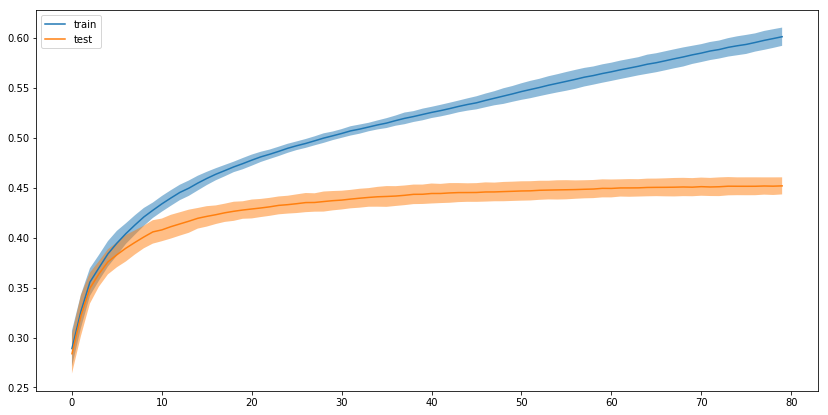

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(cv_train_mean)), cv_train_mean)
plt.fill_between(np.arange(len(cv_train_mean)), cv_train_mean-cv_train_std, cv_train_mean+cv_train_std, alpha=0.5)
plt.plot(np.arange(len(cv_train_mean)), cv_test_mean)
plt.fill_between(np.arange(len(cv_test_mean)), cv_test_mean-cv_test_std, cv_test_mean+cv_test_std, alpha=0.5)
plt.legend(['train', 'test'])

[0]	train-error:0.005811	train-MCC:0.314437
[1]	train-error:0.005811	train-MCC:0.37054
[2]	train-error:0.005811	train-MCC:0.373694
[3]	train-error:0.005811	train-MCC:0.380318
[4]	train-error:0.005811	train-MCC:0.388605
[5]	train-error:0.005811	train-MCC:0.40358
[6]	train-error:0.005811	train-MCC:0.417221
[7]	train-error:0.005811	train-MCC:0.428178
[8]	train-error:0.005811	train-MCC:0.437089
[9]	train-error:0.005811	train-MCC:0.441998
[10]	train-error:0.005811	train-MCC:0.447016
[11]	train-error:0.005811	train-MCC:0.45072
[12]	train-error:0.005811	train-MCC:0.455201
[13]	train-error:0.005811	train-MCC:0.460641
[14]	train-error:0.005811	train-MCC:0.4635
[15]	train-error:0.00581	train-MCC:0.466947
[16]	train-error:0.00581	train-MCC:0.468598
[17]	train-error:0.005803	train-MCC:0.471384
[18]	train-error:0.005792	train-MCC:0.476635
[19]	train-error:0.005755	train-MCC:0.478129
[20]	train-error:0.005717	train-MCC:0.478671
[21]	train-error:0.005666	train-MCC:0.480452
[22]	train-error:0.005624	t

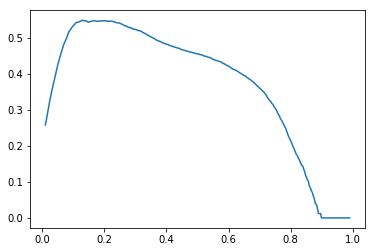

In [26]:
# Train the model
dtrain = xgb.DMatrix(x_train, label=y_train)
params['seed'] = 28537894
clf = xgb.train(params, dtrain, num_boost_round=60,
               feval=mcc_eval, evals=[(dtrain, 'train')])

y_train_pred = clf.predict(dtrain)

# Find best threshold 
thresholds = np.linspace(0.01, 0.99, 400)
mcc = np.array([matthews_corrcoef(y_train, y_train_pred>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]

print('Optimal MCC = {:.3f}'.format(mcc.max()))
print('Optimal threshold = {:.3f}'.format(best_threshold))

### Predict on test data

In [27]:
dtest = xgb.DMatrix(x_test)
y_test_pred = clf.predict(dtest)
y_test_pred_int = (y_test_pred>best_threshold).astype(int)

sub = pd.read_csv("../../data/sample_submission.csv.zip", index_col=0)
sub["Response"] = y_test_pred_int
sub.to_csv("15-benchmark_7_submission_1.csv.gz", compression="gzip")

Only With MeanTimeDiff Features:
- LB: `n_estimators=60`: Private MCC = 0.44401, public MCC = 0.43569
- CV: `n_estimators=80`: Score mean = 0.448, std = 0.013
- CV: `n_estimators=60`: Score mean = 0.445491, std = 0.0133, MCC~[0.43218, 0.45880]

Time series features, excluding MeanTimeDiff:
- LB: `n_estimators=60`: Private MCC = 0.46212, public MCC = 0.44761
- CV: `n_estimators=80`: Score mean = 0.454509, std = 0.00586
- CV: `n_estimators=60`: Score mean = 0.4534794, std = 0.0067, MCC~[0.44682, 0.46014]

Time series features, including MeanTimeDiff:
- LB: `n_estimators=60`: Private MCC = 0.43169, public MCC = 0.42776
- CV: `n_estimators=80`: Score mean = 0.452, std = 0.009
- CV: `n_estimators=60`: Score mean = 0.449, std = 0.009, MCC~[0.458029, 0.440109]

In [28]:
cv_test_mean[60]+cv_test_std[60]

0.4580296041239313

In [29]:
cv_test_mean[60]-cv_test_std[60]

0.4401097292094019

In [30]:
cv_test_mean[79]

0.45163359999999997

In [32]:
cv_test_std[60]

0.008959937457264708